<a href="https://colab.research.google.com/github/Bokocki/135UM-Homework/blob/main/Homework10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

# Solution to the homework
---
## Training the neural net

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Code from the class
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True) 

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(kernel_size = 5, in_channels = 1, out_channels = 6)
        self.conv2 = torch.nn.Conv2d(kernel_size = 5, in_channels = 6, out_channels = 16)
        self.conv3 = torch.nn.Conv2d(kernel_size = 4, in_channels = 16, out_channels = 120)
        self.pool = nn.AvgPool2d(kernel_size = 2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(120, 84)
        self.linear2 = torch.nn.Linear(84, 10)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = x.squeeze(-1).squeeze(-1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)

        x = self.dropout(x)
        return x

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()    
for epoch in range(2): 

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean")
        loss.backward()      
        optimizer.step()
    print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())

good = 0
wrong = 0

net.eval()           
with torch.no_grad():  
    for batch, data in enumerate(testloader): 
        datapoint, label = data

        prediction = net(datapoint.to(device))            
        classification = torch.argmax(prediction)

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

Working on cpu
epoch: 0 batch: 29 current batch loss: 0.896144688129425
epoch: 1 batch: 29 current batch loss: 0.5691907405853271
accuracy =  0.8808


## First task

λ=0.000, Step 0, Loss: 3.4763, P(class): [0.036, 0.002, 0.353, 0.142, 0.004, 0.265, 0.013, 0.061, 0.055, 0.005]
λ=0.000, Step 500, Loss: 0.0132, P(class): [0.993, 0.994, 0.998, 0.99, 0.99, 0.996, 0.989, 0.991, 0.984, 0.946]
λ=0.000, Step 999, Loss: 0.0043, P(class): [0.998, 0.998, 0.999, 0.997, 0.996, 0.999, 0.996, 0.997, 0.995, 0.983]
λ=0.001, Step 0, Loss: 3.4773, P(class): [0.036, 0.002, 0.353, 0.142, 0.004, 0.265, 0.013, 0.061, 0.055, 0.005]
λ=0.001, Step 500, Loss: 0.0148, P(class): [0.993, 0.994, 0.997, 0.989, 0.99, 0.996, 0.989, 0.991, 0.984, 0.945]
λ=0.001, Step 999, Loss: 0.0062, P(class): [0.998, 0.998, 0.999, 0.996, 0.996, 0.999, 0.996, 0.997, 0.995, 0.982]
λ=0.010, Step 0, Loss: 3.4864, P(class): [0.036, 0.002, 0.353, 0.142, 0.004, 0.265, 0.013, 0.061, 0.055, 0.005]
λ=0.010, Step 500, Loss: 0.0268, P(class): [0.992, 0.994, 0.997, 0.988, 0.989, 0.995, 0.989, 0.99, 0.983, 0.943]
λ=0.010, Step 999, Loss: 0.0172, P(class): [0.997, 0.997, 0.998, 0.995, 0.996, 0.998, 0.995, 0.996

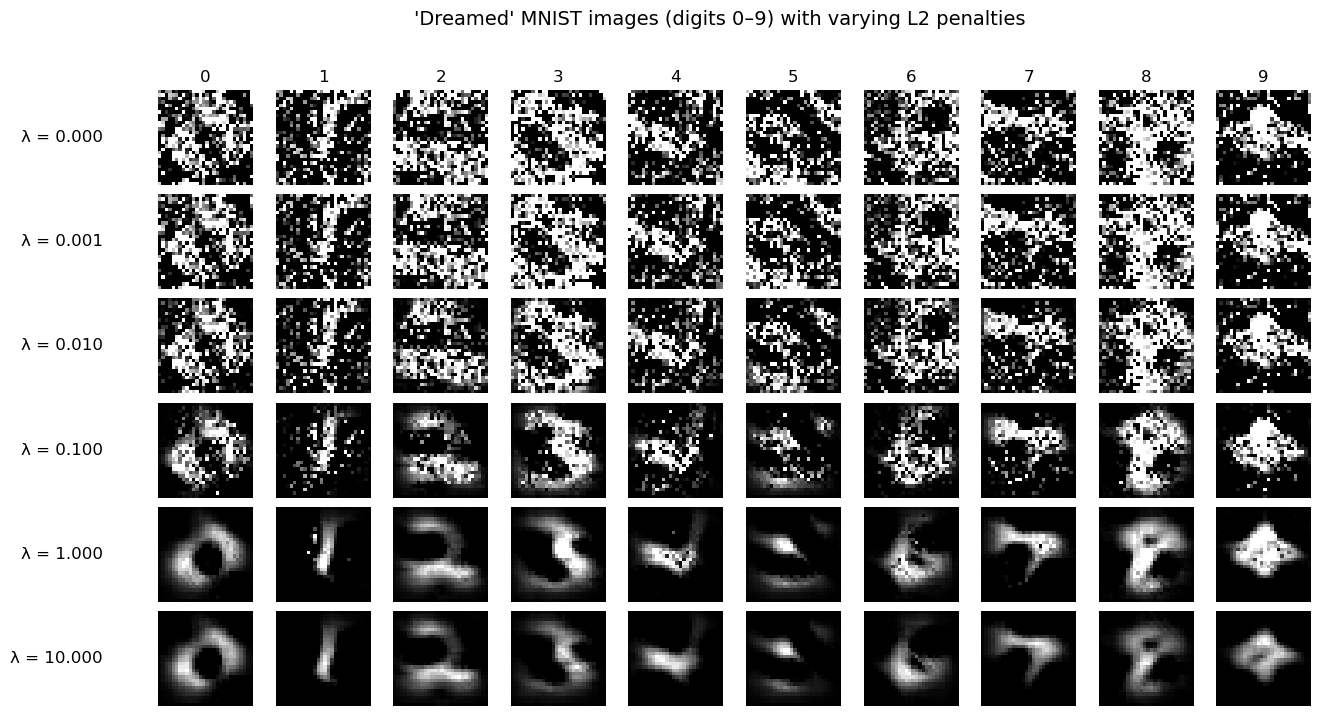

In [2]:
# Setting up network
net.eval()

# Generating 10 random gaussian noise iamges
base_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# Setting target classes for images
target_classes = torch.arange(10, device=device)

# Preparing set of lambda values
lambda_values = [0, 0.001, 0.01, 0.1, 1.0, 10.0]

# Preparing for further vizualization
fig, axs = plt.subplots(len(lambda_values), 10, figsize=(15, 8))
if len(lambda_values) == 1:
    axs = axs.unsqueeze(0)

# "Dreaming" procedure for every lambda
for i, lambda_l2 in enumerate(lambda_values):

    # Getting input images
    dreamed_inputs = base_inputs.clone().detach().requires_grad_(True)

    # Preparing optimizer
    optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

    # Optimizing procedure
    for step in range(1000):
        optimizer.zero_grad()
        logits = net(dreamed_inputs)
        probs = F.softmax(logits, dim=1)
        target_loss = F.cross_entropy(logits, target_classes)

        # Introducing L2 penalty to loss function
        l2_penalty = lambda_l2 * dreamed_inputs.pow(2).mean()
        loss = target_loss + l2_penalty

        loss.backward()
        optimizer.step()

        # Displaying values of loss function and probabilities of "correct" classification
        if step % 500 == 0 or step == 999:
            prob_class = probs.gather(1, target_classes.view(-1, 1))
            print(f"λ={lambda_l2:.3f}, Step {step}, Loss: {loss.item():.4f}, P(class): {[round(p.item(), 3) for p in prob_class]}")

    # Vizualization section
    images = dreamed_inputs.detach().cpu().clamp(0, 1)

    for j in range(10):
        ax = axs[i, j]
        ax.imshow(images[j, 0], cmap='gray')
        ax.axis('off')

        # Labeling each row with lambda
        if j == 0:
            ax.annotate(f"λ = {lambda_l2:.3f}", xy=(0, 0.5), xycoords='axes fraction',
                        fontsize=12, ha='right', va='center', rotation=0,
                        xytext=(-40, 0), textcoords='offset points')
        if i ==0:
            ax.set_title(str(j), fontsize=12)

plt.suptitle("'Dreamed' MNIST images (digits 0–9) with varying L2 penalties", fontsize=14)
plt.subplots_adjust(top=0.88, left=0.12, wspace=0.05, hspace=0.1)
plt.show()

Just like in Homework 9, we observe that with low regularization (small or zero L2 penalty), the generated images remain noisy and lack any recognizable structure – they do not resemble digits and are essentially uninterpretable to humans. As we increase the regularization strength, however, a clear difference emerges compared to the previous experiment with a fully connected network – the generated images under higher regularization are significantly more human-readable. Many of them begin to resemble actual handwritten digits and match the style of MNIST digits.

This improved readability is largely due to the architectural properties of convolutional neural networks (CNNs). CNNs are designed to exploit the spatial structure of images by using local filters that detect features such as edges, textures, and shapes. These filters are shared across the image, allowing the network to learn spatially invariant features that are crucial for interpreting visual data. As a result, CNNs learn a feature space that is more aligned with human visual perception.

In contrast, fully connected networks lack this inductive bias toward local and spatial structure, so their internal representations are less aligned with image-like patterns. As a result, optimizing inputs to activate certain classes tends to produce more abstract or chaotic patterns that don't resemble natural images, even under regularization.

## Second task

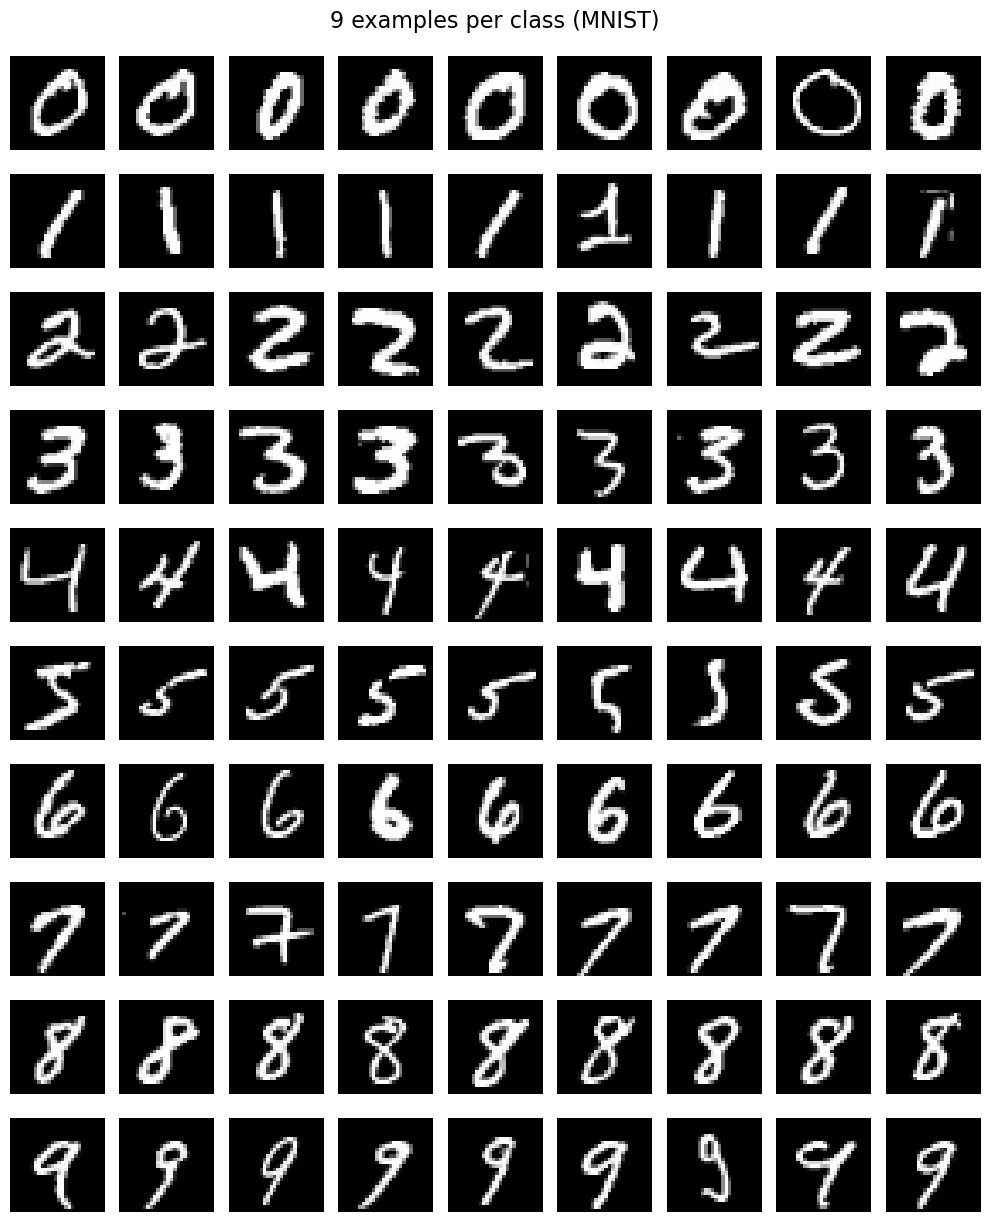

In [3]:
# Defining function that will export 9 images from each class
def get_nine_per_class(device='cuda'):

    # Preparing dataset
    transform = transforms.ToTensor()
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    images = {i: [] for i in range(10)}

    # Loop that collects 9 distinct images for every class
    for img, label in dataset:
        if len(images[label]) < 9:
            images[label].append(img)
        if all(len(v) == 9 for v in images.values()):
            break

    all_imgs, all_labels = [], []

    # Gathers all images in one list (all_imgs) and all labels (all_labels)
    for label in range(10):
        all_imgs.extend(images[label])
        all_labels.extend([label] * 9)

    return torch.stack(all_imgs).to(device), torch.tensor(all_labels, device=device)

# Defining function for plotting original digits
def plot_nine_per_class(images, labels):
    fig, axs = plt.subplots(10, 9, figsize=(10, 12))
    for i in range(10):
        for j in range(9):
            idx = i * 9 + j
            axs[i, j].imshow(images[idx].cpu().squeeze(), cmap='gray')
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_ylabel(f"Label {i}", fontsize=10)
    plt.tight_layout()
    plt.suptitle("9 examples per class (MNIST)", fontsize=16, y=1.02)
    plt.show()

images, labels = get_nine_per_class(device=device)
plot_nine_per_class(images, labels)

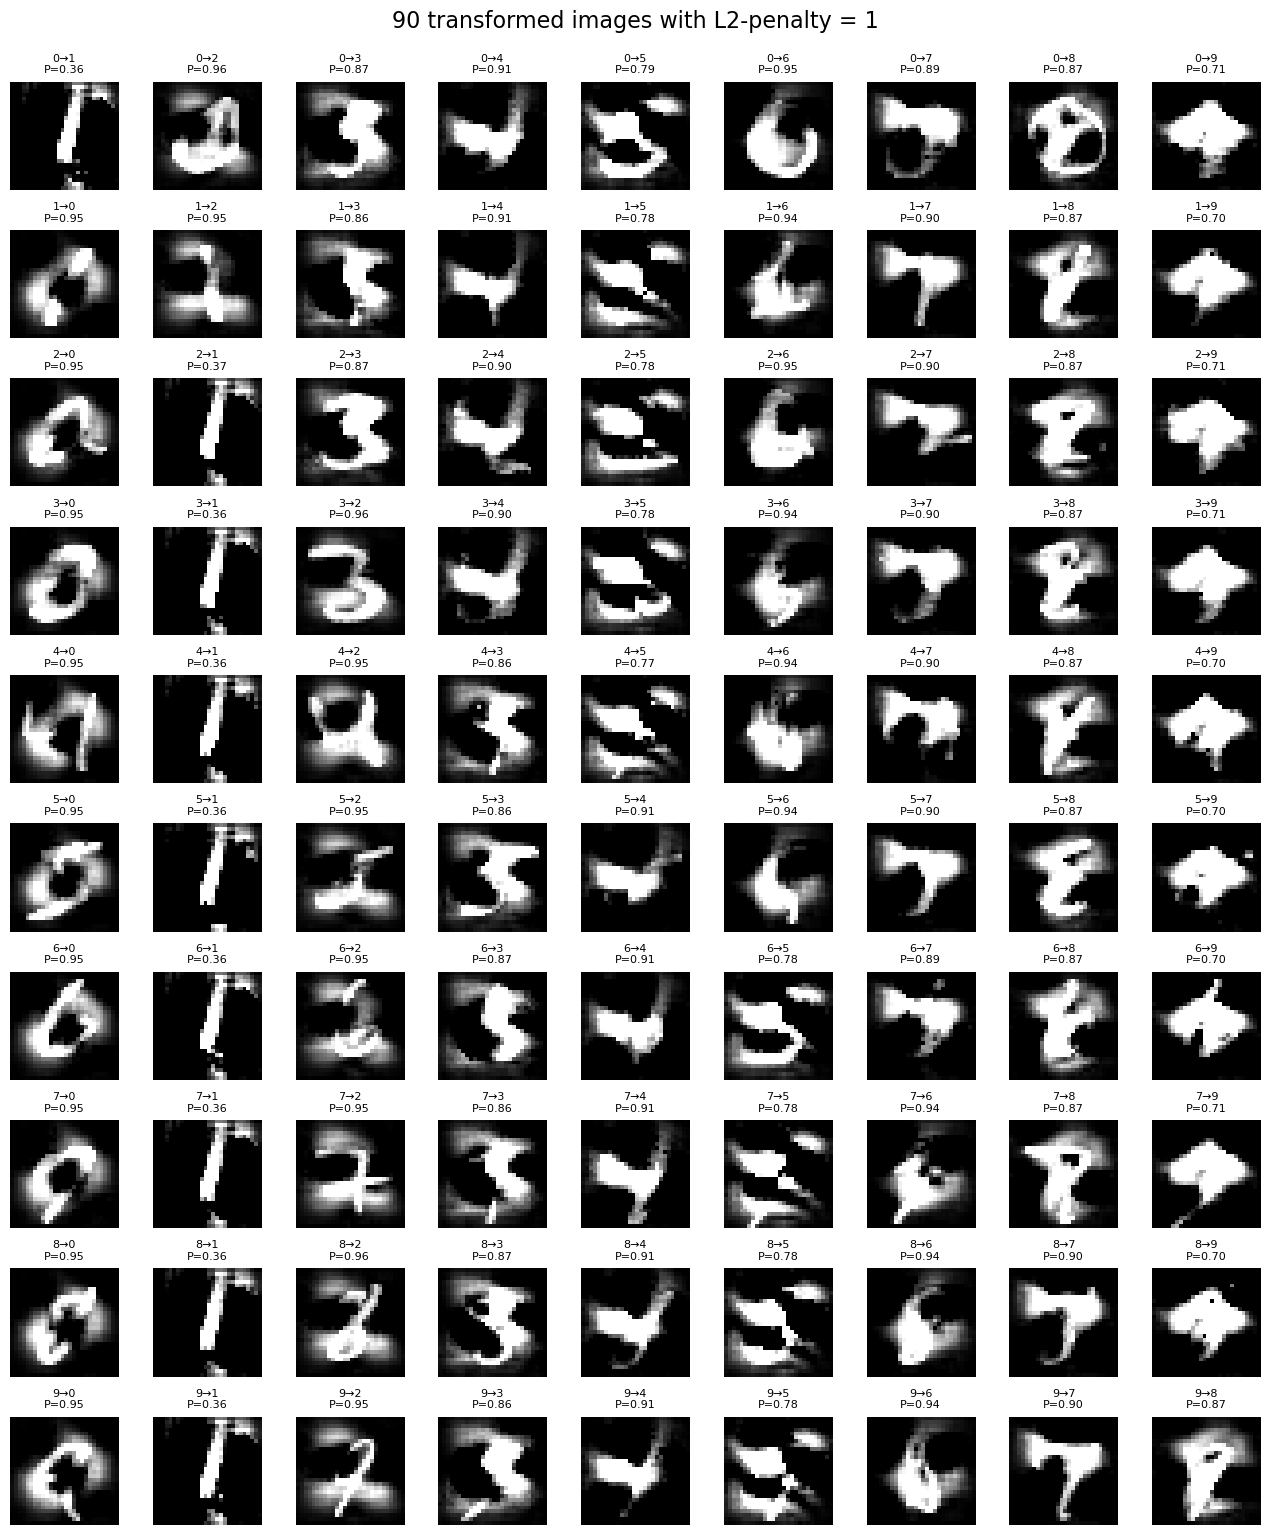

In [4]:
# Defining function that will generate new target labels
# We will use this function to set target labels in process of adding noise that will fool neural network
def generate_target_labels(true_labels):
    target_labels = []

    # Loop that generates target classes for transformed images
    for label in true_labels[::9]:
        # Other than true class
        others = [i for i in range(10) if i != label.item()]
        target_labels.extend(others)
    return torch.tensor(target_labels, device=true_labels.device)

# Defining function for training images that will fool neural net
def generate_adversarials_one_to_each(net, images, true_labels, target_labels, lambda_l2=1, steps=1000, device='cuda'):
    # Setting neural net
    net.eval()

    # List for adversial images
    adversarials = []

    # List for probabilities (of classification one image as target class)
    probs = []

    # Loop for every image
    for idx in range(len(images)):

        # Setting image for further transformation
        orig = images[idx:idx+1]

        # Setting target label
        target = target_labels[idx].item()

        # Random noise that will be trained to fool neural net
        delta = torch.zeros_like(orig, requires_grad=True)

        # Setting optimizer for further training
        optimizer = torch.optim.Adam([delta], lr=0.01)

        # Training loop
        for step in range(steps):
            
            # Freezing weights
            optimizer.zero_grad()

            # Setting up loss function with delta
            perturbed = (orig + delta).clamp(0, 1)
            logits = net(perturbed)
            loss = F.cross_entropy(logits, torch.tensor([target], device=device)) + lambda_l2 * delta.pow(2).mean()

            # Optimizing
            loss.backward()
            optimizer.step()

        # Saving transformed image
        adv_img = (orig + delta).detach().clamp(0, 1)
        adversarials.append(adv_img)

        # Calculating probability that transfored image is in target (not true) class
        with torch.no_grad():
            logits = net(adv_img)
            prob = F.softmax(logits, dim=1)[0, target].item()
            probs.append(prob)

    return adversarials, probs

# Defining function that will plot results
def plot_adv_grid_90(orig_images, orig_labels, adv_images, target_labels, probs, penalty):

    # Plotting section
    fig, axs = plt.subplots(10, 9, figsize=(13, 15))
    # Showing results for 90 images
    for i in range(10):
        for j in range(9):
            idx = i * 9 + j

            # Plotting image
            axs[i, j].imshow(adv_images[idx].cpu().squeeze(), cmap='gray')

            # Showing label for every image in form:
            # (original class → new class we achieved by fooling)
            # (probability that transformed image belongs to "untrue" class)
            axs[i, j].set_title(f"{orig_labels[idx].item()}→{target_labels[idx].item()}\nP={probs[idx]:.2f}", fontsize=8)
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.suptitle(f"90 transformed images with L2-penalty = {penalty}", fontsize=16, y=1.02)
    plt.show()

# Setting neural network
net.eval()

# Getting taget "untrue" labels
target_labels = generate_target_labels(labels)

# Training procedure with low l2 penalty
adversarials, probs = generate_adversarials_one_to_each(net, images, labels, target_labels,
                                                        lambda_l2=1, steps=1000, device=device)

# Plotting results
plot_adv_grid_90(images, labels, adversarials, target_labels, probs, penalty=1)

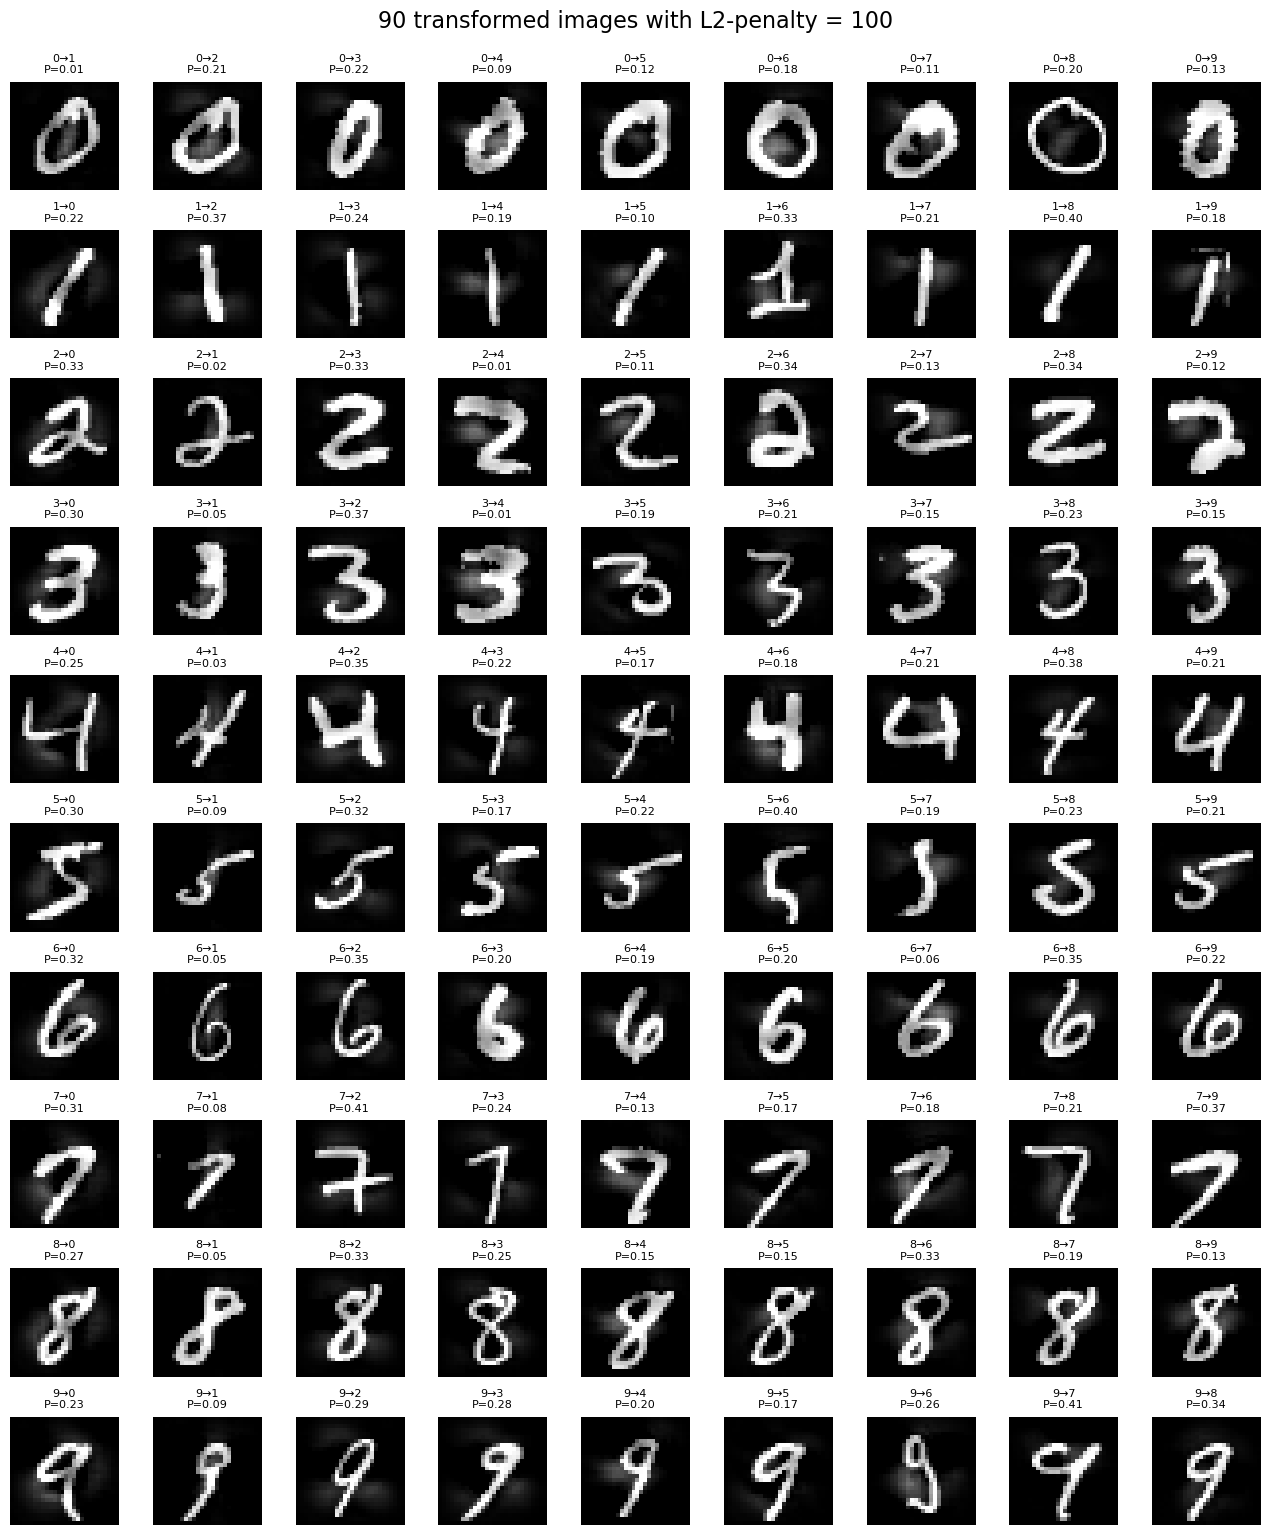

In [5]:
# Training procedure with high l2 penalty
adversarials, probs = generate_adversarials_one_to_each(net, images, labels, target_labels,
                                                        lambda_l2=100, steps=1000, device=device)

# Plotting results
plot_adv_grid_90(images, labels, adversarials, target_labels, probs, penalty=100)

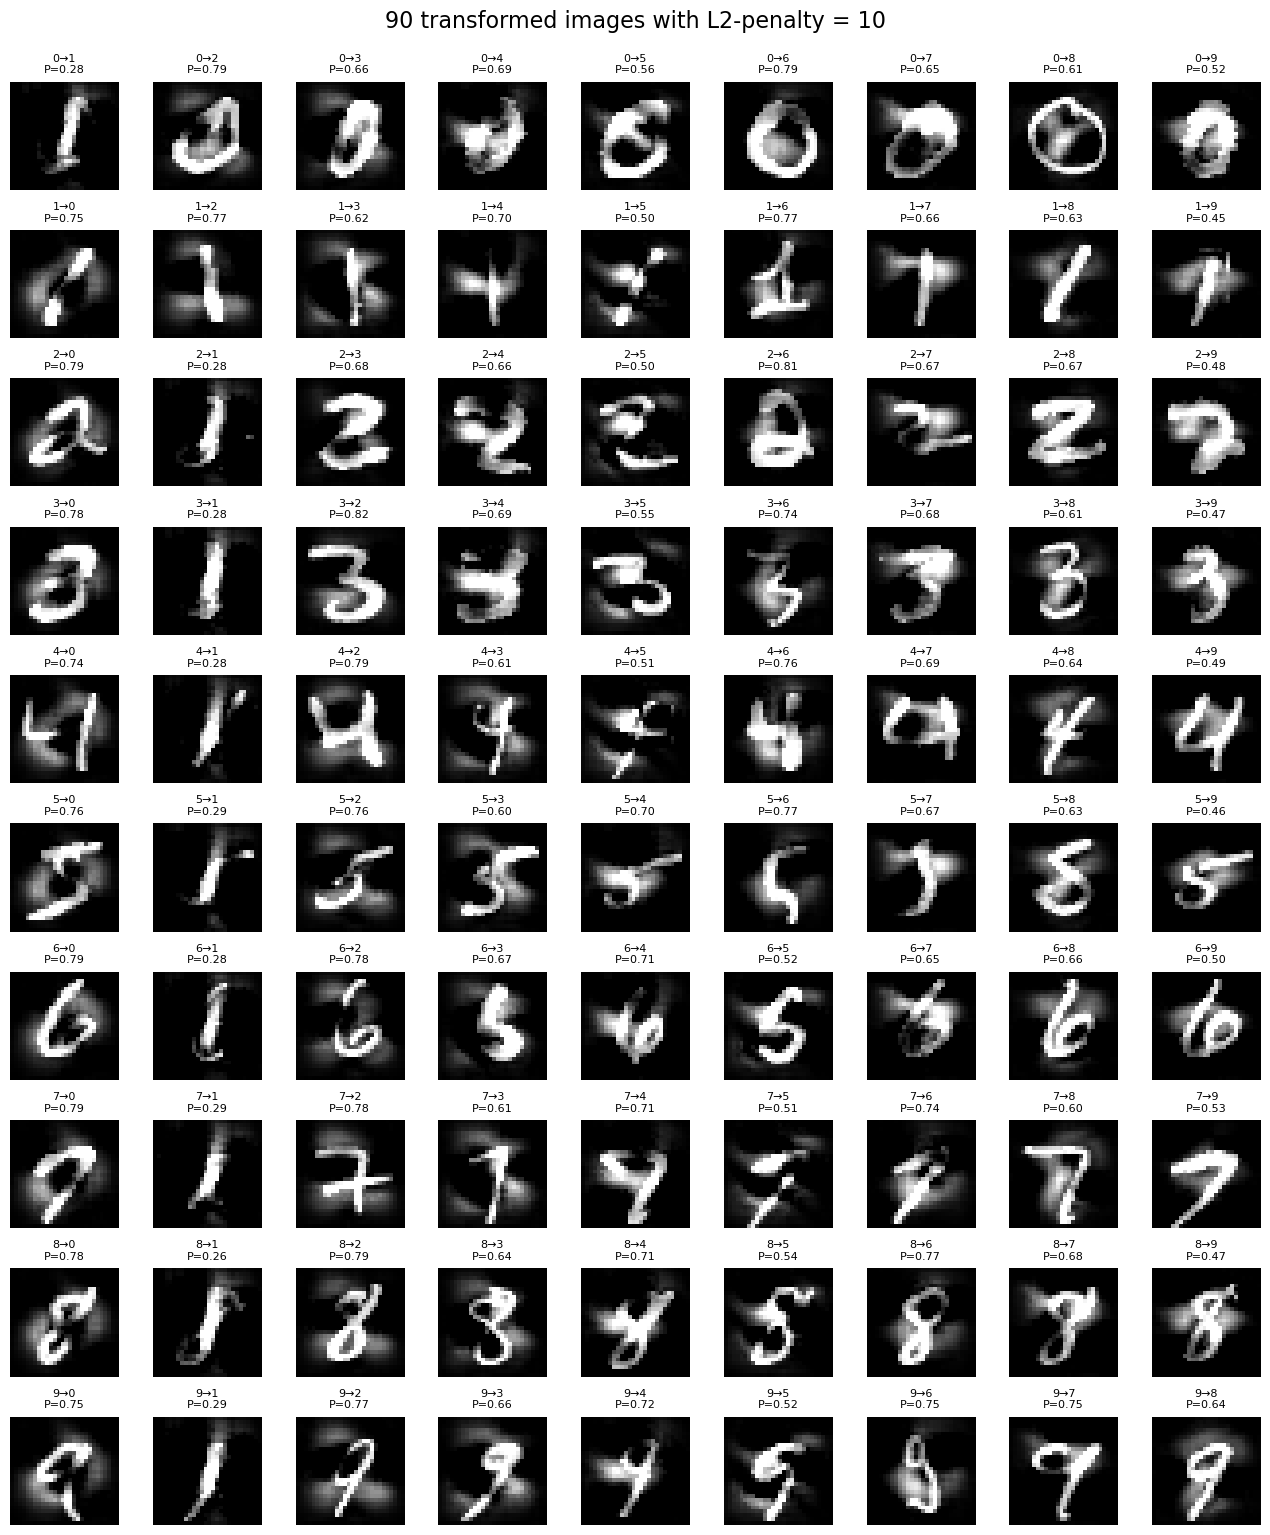

In [6]:
# Training procedure with medium l2 penalty
adversarials, probs = generate_adversarials_one_to_each(net, images, labels, target_labels,
                                                        lambda_l2=10, steps=1000, device=device)

# Plotting results
plot_adv_grid_90(images, labels, adversarials, target_labels, probs, penalty=10)

The first grid displays a selection of original MNIST digits used for the adversarial experiments. We chose 9 examples from each digit class (0–9), arranged row-wise by class. For every image, we generated an adversarial counterpart designed to fool the network into predicting a target label different from the true one. This setup allows us to evaluate how perturbations can mislead the model, even when the original class is visually clear.

In the second grid, we present the adversarial images obtained using a low L2 penalty ($\lambda = 1$). Here, the optimization is free to introduce relatively large perturbations. As a result, the images are visibly distorted – sometimes quite far from the original class. However, this comes with high effectiveness – the network is frequently fooled into predicting the target class with high confidence (as indicated by the displayed probabilities).

The third grid corresponds to a high L2 penalty ($\lambda = 100$), which severely constrains how much the image can be altered. The adversarial examples remain almost identical to the originals, and thus are visually clear and easily recognizable by humans. However, because the noise is so limited, the network is rarely fooled – the confidence in the incorrect class is generally very low.

The final grid uses a moderate L2 penalty ($\lambda = 10$), striking a balance between distortion and effectiveness. These adversarial images still resemble the original digits and remain human-interpretable, yet they are often enough to mislead the network with moderate-to-high confidence. For this reason, we select this penalty for further analysis.

Below, we present a side-by-side comparison of original and adversarial images for each class, highlighting cases where the transformed image remains visually consistent with the original label, yet the network confidently misclassifies it.

![HW10-0-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-0-org.png)
![HW10-0.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-0.png)

![HW10-1-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-1-org.png)
![HW10-1.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-1.png)

![HW10-2-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-2-org.png)
![HW10-2.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-2.png)

![HW10-3-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-3-org.png)
![HW10-3.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-3.png)

![HW10-4-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-4-org.png)
![HW10-4.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-4.png)

![HW10-5-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-5-org.png)
![HW10-5.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-5.png)

![HW10-6-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-6-org.png)
![HW10-6.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-6.png)

![HW10-7-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-7-org.png)
![HW10-7.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-7.png)

![HW10-8-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-8-org.png)
![HW10-8.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-8.png)

![HW10-9-org.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-9-org.png)
![HW10-9.png](https://raw.githubusercontent.com/Bokocki/135UM-Homework/refs/heads/main/HW10_images/HW10-9.png)